# Imports

In [1]:
from modules.data import  data_reader
from modules.models import lag_llama
from modules.experiment.tscv import get_tscv_results, get_summary, extract_metrics
from modules.visualization import graphs
from modules.fine_tuning import lag_llama_ft


# Parameters

In [2]:
# experiment parameters
#constraint: FOLDS x PREDICTION_LENGTH + TRAIN_SIZE !!must not!! be bigger than len(data)

PREDICTION_LENGTH = 5 # currentlz only works for PREDICTION_LENGTH > 1
FREQUENCY = "hourly" # currently we only have dailz frequency
TYPE_OF_DATA = "return" # currently we only have stock prices saved
MODELS = ["arima", "llama", "autoregressor", "fine-tuned Llama"] # currentlz works onlz for these two
FOLDS = 2 # for TSCV # reduced to two for testing purposes
CONTEXT_LENGTH = 64
METRICS = ['r2', 'mse', 'mae', 'rmse', 'mda', "mape"]

# fine-tuning parameters
BATCH_SIZE = 10
MAX_EPOCHS = 2

FT_START_DATE = "2022-07-07"
START_DATE = "2023-07-07"
END_DATE = "2024-07-07"
# want to add
#TRAIN_PERIOD = # context lenghts. Should take a look into this
TRAIN_SIZE = CONTEXT_LENGTH




# Reading the data

In [3]:
data = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY)
# this is just in case there are more CSVs of the same type and frequency, the data should be the first in the list
#if len(data) > 1:
data = data[0]

simple_data = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY, match = ["simple"])
#if len(simple_data) > 1:
simple_data = simple_data[0]

train_data = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY, match = ["train"])
train_data = train_data[0]

test_data = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY, match = ["test"])
test_data = test_data[0]

In [4]:
# temporary for testing purposes
simple_data=train_data

# Downloading the data

# Models

In [5]:
# arima


In [6]:
# lag llama

# Fine tuning an estimator

In [7]:
#preparing the training data for lag llama fine tuning
ft_train_data = lag_llama.prepare_data(data=train_data, 
                                       prediction_length=0, 
                                       frequency=FREQUENCY)

In [8]:
# creating the lag llama predictor object 
predictor = lag_llama_ft.get_predictor(prediction_length=PREDICTION_LENGTH, 
                                       context_length=CONTEXT_LENGTH, 
                                       batch_size=BATCH_SIZE, 
                                       max_epochs=MAX_EPOCHS)

In [9]:
# fine-tuning the predictor object
predictor = predictor.train(ft_train_data, 
                            cache_data = True, 
                            shuffle_buffer_length = 1000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\topco\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached -2.77185 (best -2.77185), saving model to 'c:\\Users\\topco\\Dokumenti\\MSc Banking and Digital Finance UCL\\Modules\\Dissertation\\MSc_dissertation\\lightning_logs\\version_1\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached -3.53485 (best -3.53485), saving model to 'c:\\Users\\topco\\Dokumenti\\MSc Banking and Digital Finance UCL\\Modules\\Dissertation\\MSc_dissertation\\lightning_logs\\version_1\\checkpoints\\epoch=1-step=100.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=2` reached.


# SKLearn TSCV

In [10]:
r, p, a = get_tscv_results(data = simple_data,
                           prediction_horizon=PREDICTION_LENGTH,
                           context_length=CONTEXT_LENGTH, 
                           folds=FOLDS, 
                           frequency=FREQUENCY, 
                           predictor=predictor)

C:\Users\topco\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Forecasting batches:   0%|          | 0/1 [00:00<?, ?it/s]

Fold 1/2 finished in: 9.75 seconds
Prediction from   2024-06-24   until   2024-06-28
----------------------


C:\Users\topco\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Forecasting batches:   0%|          | 0/1 [00:00<?, ?it/s]

Fold 2/2 finished in: 10.72 seconds
Prediction from   2024-07-01   until   2024-07-08
----------------------


In [11]:
#creating the summary for each model
s = [get_summary(r[i]) for i in range(len(r))]

In [12]:
means_df, medians_df, stds_df = extract_metrics(s, MODELS)

# Visualisation

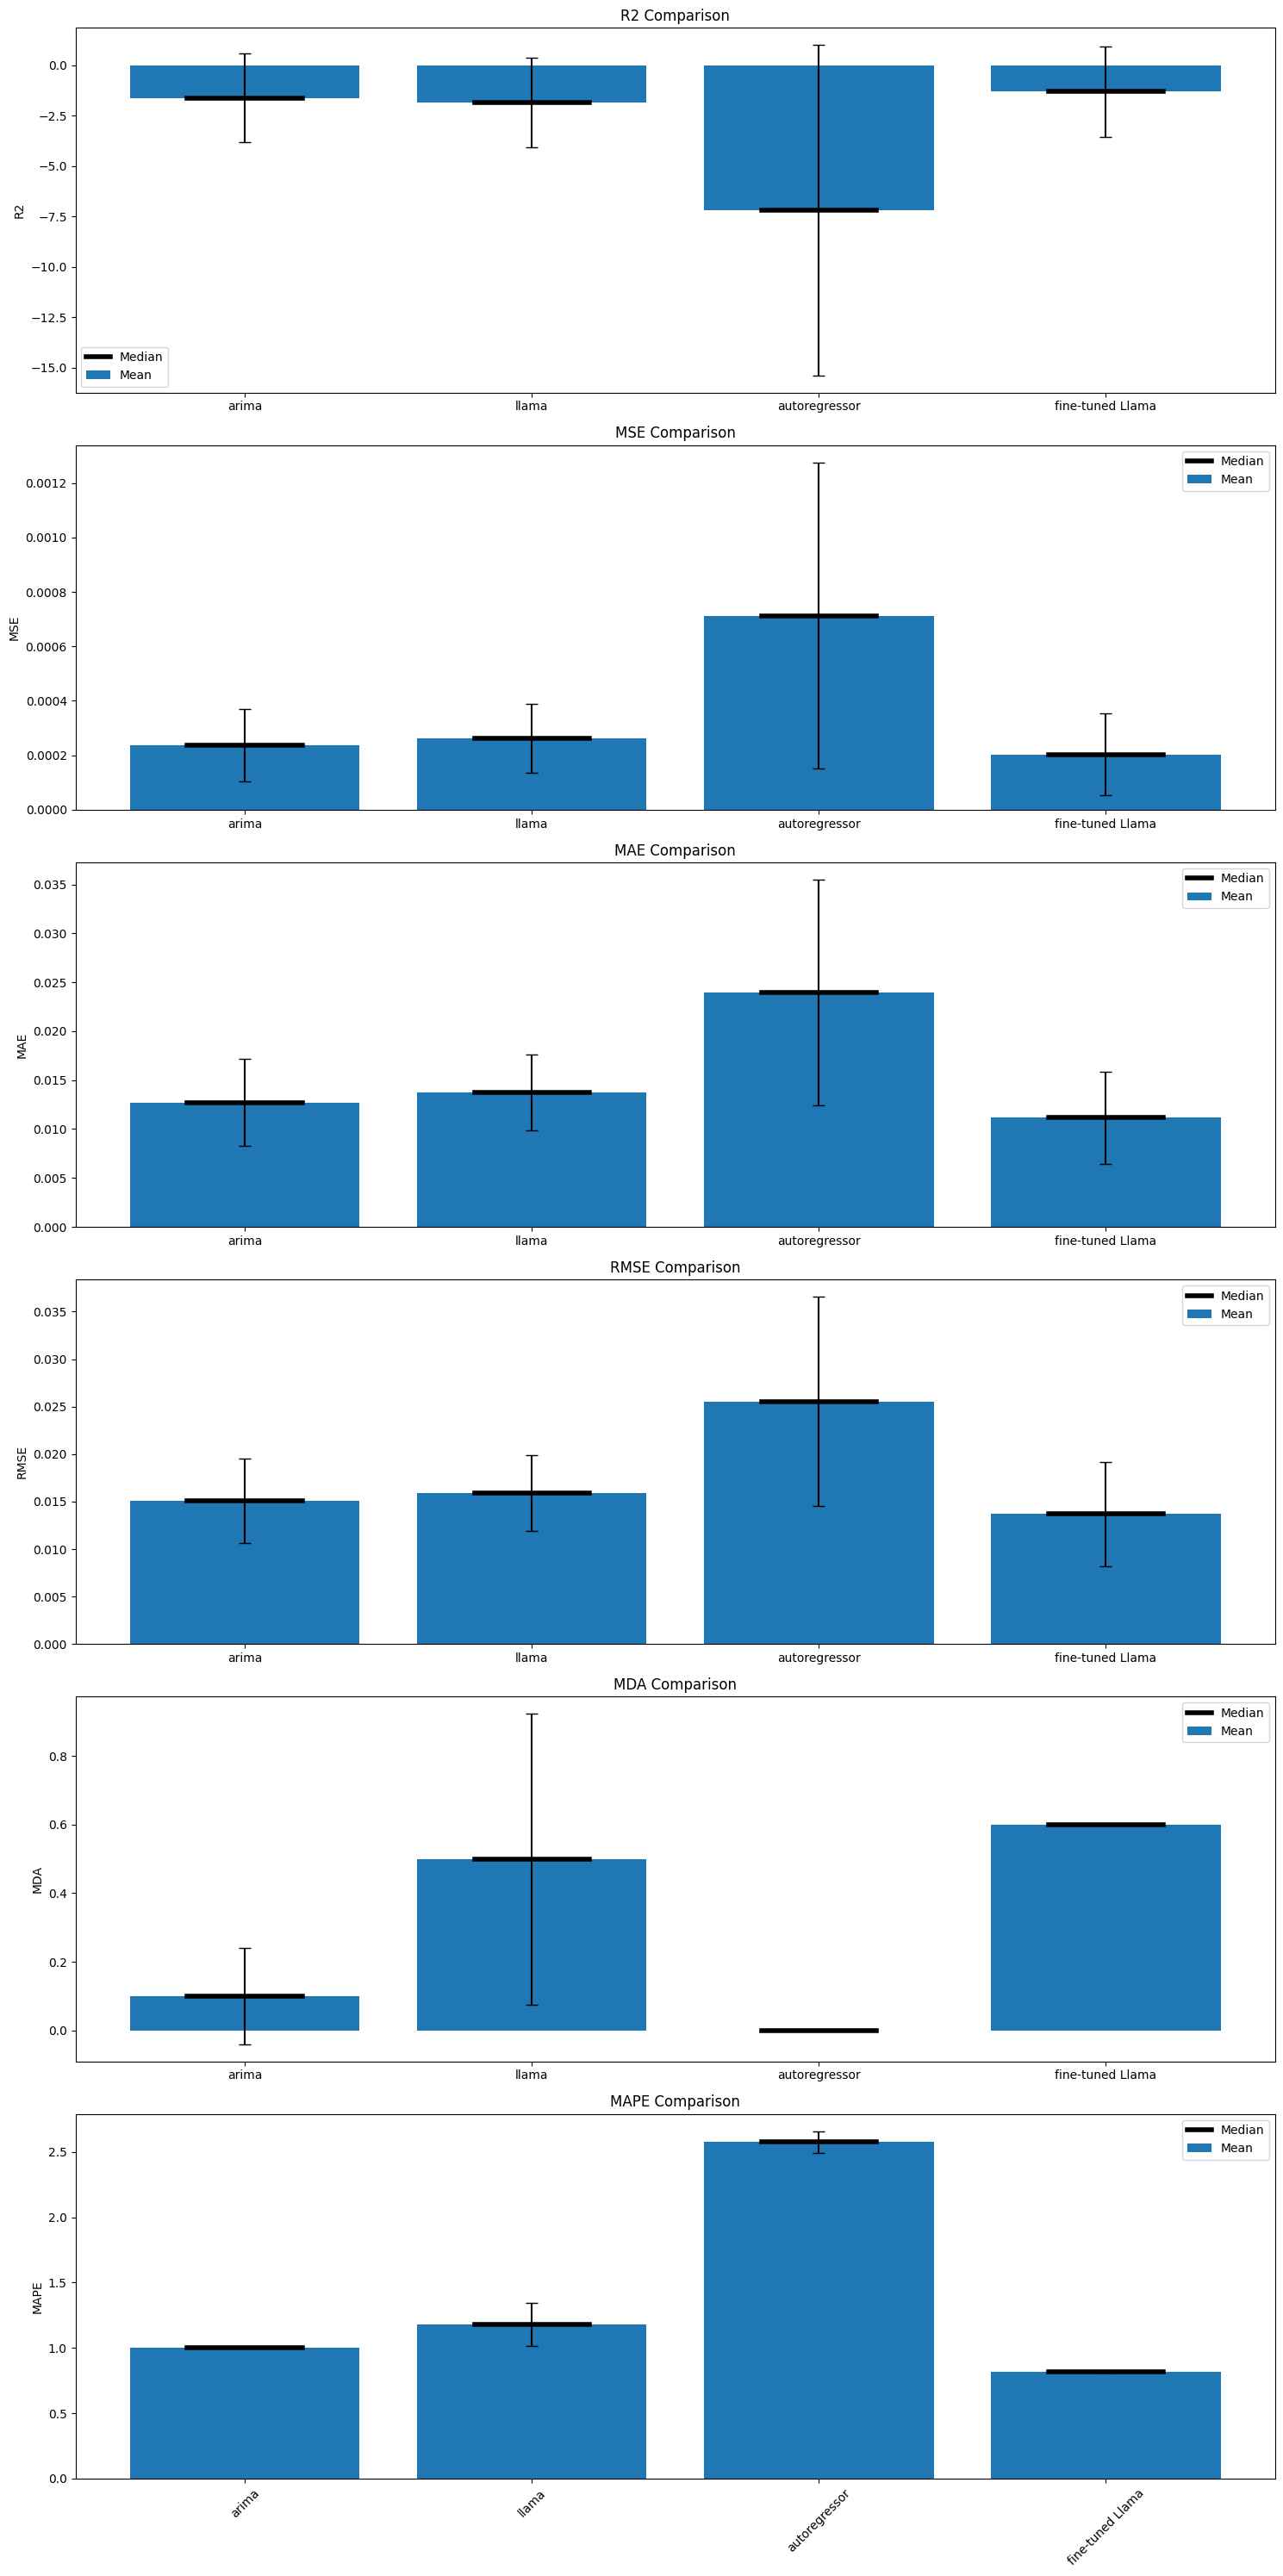

In [13]:
graphs.standard_visualisation(MODELS, METRICS, s)

In [14]:
graphs.interactive_visualisation(MODELS, METRICS, s)

In [15]:
graphs.prediction_visualisation(MODELS, p, a)

LABEL the graph
label the axes with timestamps
show the history of the actual
table of comparison, not just graph